# Session 3 - Learning CY metric

In this session we will implement custom loss and training functions to learn numerical approximations of Calabi Yau metrics.

There has [recently](https://arxiv.org/abs/1910.08605) been interest in using ML to approximate CY metrics. The authors, however, used a combination of conventional curve fitting and tree based methods. In this notebook, we will use neural networks to approximate (the determinant of) the metric.

In [1]:
import numpy as np
import tensorflow as tf
import itertools as it
import matplotlib.pyplot as plt
tfk = tf.keras

## Loading the data

I have prepared 100000 points on the fermats quintic

$$
Q = \sum_i z_i^5 = 0
$$

The dataset also includes some integration weights

$$
w = 5^{-2} |z_j|^{-8} (\det(i^*\omega^{FS}_{\mathbb{P}^4}))^{-1}
$$

and the evaluation of the holomorphic volume form at each point

$$
\Omega \wedge \bar{\Omega}|_{p_i} = 5^{-2} |z_j|^{-8}
$$

with coordinates $p = (1,z_j, x_1, x_2, x_3)$.

In [2]:
fname = 'fermat_data.npy'
point_weights_omega = np.load(fname)
points = np.hstack([point_weights_omega['point'].real, point_weights_omega['point'].imag]) 
weights = point_weights_omega['weight'].reshape((-1,1))
omega = point_weights_omega['omega'].reshape((-1,1))
features = np.concatenate((points, weights, omega), axis=-1)
features.shape

(100000, 12)

In [3]:
np.random.shuffle(features)
train_index = int(0.8 * len(features))
x_train = features[0:train_index]
y_train = x_train
x_test = features[train_index:]
y_test = x_test

## Tensorflow Custom loss

We will approximate the hermitian (nfold,nfold) metric with a neural network. First, we have to write a function that takes the 9 floating point outputs and puts them into a 3x3 hermitian matrix.

In [4]:
def to_hermitian(x):
    t1 = tf.reshape(tf.complex(x, tf.zeros(9, dtype=tf.float32)), (3,3))
    up = tf.linalg.band_part(t1, 0, -1)
    low = tf.linalg.band_part(1j * t1, -1, 0)
    out = up + tf.transpose(up) - tf.linalg.band_part(t1, 0, 0)
    return out + low + tf.math.conj(tf.transpose(low))

to_hermitian_batch = tf.function(lambda y_pred : tf.vectorized_map(to_hermitian, y_pred))

Next we will have to think how to optimize our neural network.

There are two scalar quantities, the sigma measure

$$
\sigma  = \frac{1}{N_t \text{Vol}_\text{CY}} \sum_{i = 1}^{N_t} | 1 - \frac{\omega^3(p_i) / \text{Vol}_\text{K} }{ \Omega(p_i) \wedge \bar{\Omega(p_i)} / \text{Vol}_\text{CY}} | w_i
$$

and the ricci measure

$$
|| R ||  = \frac{1}{N_t \text{Vol}_\text{CY}^{2/3}} \sum_{i = 1}^{N_t}  \frac{\omega^3(p_i) }{ \Omega(p_i) \wedge \bar{\Omega(p_i)} } \lvert R(p_i) \rvert w_i
$$

where

$$
	 \text{Vol}_\text{CY} = \frac{1}{N} \sum_i^N w_i, \qquad  \text{Vol}_\text{K} = \frac{1}{N} \sum_i^N \frac{\omega^3(p_i)}{\Omega (p_i) \wedge \bar{\Omega} (p_i) } w_i .
$$

Computing second order derivative is fairly expensive, thus we will stick to the sigma measure for this tutorial. (Note: There is an ambiguity with the absolute value in the sigma measure, which often results in ill defined metrics with neg det. We also won't check if they are in fact Ricci flat, but are only interested in the volume in this Notebook)

In [5]:
def sigma_loss_batch(y, g):

    bSize = tf.cast(tf.shape(y)[0], dtype=tf.float32)
    g = to_hermitian_batch(g)
    weights, omega = y[:,-2], y[:,-1]
    volume_cy = tf.math.reduce_sum(weights, axis=-1) / bSize
    det = tf.math.real(tf.linalg.det(g))
    omega_over_omega = det / omega
    vol_k = tf.math.reduce_sum(omega_over_omega * weights, axis=-1) / bSize
    ratio = volume_cy / vol_k
    sigma_integrand = tf.abs(tf.ones(tf.shape(omega_over_omega), dtype=tf.float32) - omega_over_omega * ratio) * weights
    sigma = tf.math.reduce_sum(sigma_integrand) / (bSize * volume_cy)
    return sigma * tf.ones(tf.shape(weights), dtype=tf.float32)


## Bayesian optimization

Let's give this a shot. We try BO using Gaussian Processes. Also check out the very nice notebooks [here (GP)](https://krasserm.github.io/2018/03/19/gaussian-processes/) and [here (BO using GP)](https://krasserm.github.io/2018/03/21/bayesian-optimization/).
First we have to write a function that creates our model.

In [6]:
def make_model(act, nHidden, nlayer, lr=0.001, dropout=0.1,
               l1l2 = 0.0001, alpha = 0.99, nfold = 3):
    model = tf.keras.Sequential()
    model.add(tfk.Input(shape=(12)))
    for i in range(nlayer):
        if act == 0:
            model.add(tfk.layers.Dense(nHidden, activation='tanh',
                                       kernel_regularizer=tfk.regularizers.l1_l2(l1=l1l2, l2=l1l2)))
        else:
            model.add(tfk.layers.Dense(nHidden, activation='relu',
                                       kernel_regularizer=tfk.regularizers.l1_l2(l1=l1l2, l2=l1l2)))
        model.add(tfk.layers.Dropout(dropout))
    model.add(tfk.layers.Dense(nfold**2))
    model.compile(optimizer=tfk.optimizers.SGD(learning_rate=lr, momentum=alpha), 
                    loss=sigma_loss_batch)
    return model

#### Gaussian process

We use the package [BayesianOptimization](https://github.com/fmfn/BayesianOptimization), since we are lazy.

In [7]:
from bayes_opt import BayesianOptimization

We need to define a function to maximize. Furthermore, BO, only works with floats. Hence, we have to round the categorical and integer choices. We start with accuracy function, the quantity we want to maximize.

In [8]:
def get_loss(act, nHidden, nlayer, lr=0.001, dropout=0.1, l1l2=0.0001,
                 alpha = 0.99, nEpochs=10, bSize=32, verbose=0):
    m = make_model(act, nHidden, nlayer, lr, dropout, l1l2, alpha)
    # exception to catch ocassional tf error
    try:
        history = m.fit(x_train, y_train, epochs=nEpochs, batch_size=bSize,
                   validation_data=(x_test, y_test), verbose=verbose)
        loss = history.history['val_loss'][-1]
    except Exception:
        loss = 1
        pass
    return loss

maximizing function

In [9]:
def f(act, nHidden, nLayer, lr, dropout, l1l2, alpha, bSize, nEpochs=10):
    # transform to ints
    int_act = int(round(act))
    int_nLayer = int(round(nLayer))
    int_nHidden = int(round(nHidden))
    int_bSize = int(round(bSize))
    log_lr = np.power(10,lr)
    log_l1l2 = np.power(10,l1l2)
    loss = get_loss(int_act, int_nHidden, int_nLayer, log_lr,
                       dropout, log_l1l2, alpha, nEpochs, int_bSize)
    return 1-loss

the optimizer

In [10]:
new_optimizer = BayesianOptimization(
    f = f,
    pbounds={"act": (0,1), "nHidden": (32, 256), "nLayer": (1,4),
             "lr": (-4, -1), "dropout": (0,0.5), "l1l2": (-6,-1),
            "alpha": (0, 0.99), "bSize": (16,256)},
    verbose=2,
    random_state=7,
)

In [11]:
new_optimizer.maximize(
    init_points=8,
    n_iter=22,
)

|   iter    |  target   |    act    |   alpha   |   bSize   |  dropout  |   l1l2    |    lr     |  nHidden  |  nLayer   |
-------------------------------------------------------------------------------------------------------------------------


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  1        |  0.692    |  0.07631  |  0.7721   |  121.2    |  0.3617   | -1.11     | -2.385    |  144.3    |  1.216    |
|  2        |  0.5232   |  0.2684   |  0.4949   |  179.0    |  0.4019   | -4.095    | -3.802    |  96.54    |  3.729    |
|  3        |  0.763    |  0.2134   |  0.4476   |  239.5    |  0.01245  | -2.997    | -1.15     |  83.59    |  2.645    |
|  4        | -0.8765   |  0.9091   |  0.1318   |  141.6    |  0.3752   | -2.655    | -2.597    |  77.89    |  2.472    |
|  5        | -0.4192   |  0.3724   |  0.4726   |  103.8    |  0.419    | -2.157    | -3.058    |  160.3    |  1.828    |
|  6        |  0.1704   |  0.4528   |  0.3494   |  173.8    |  0.1852   | -3.705    | -1.842    |  124.5    |  3.719    |
|  7        |  0.73     |  0.1805   |  0.7337   |  117.4    |  0.2132   | -2.828    | -2.431    |  124.9    |  1.004    |
|  8        |  0.6823   |  0.09226  |  0.7023   |  141.8    |  0.3481   | -1.223    | -1.951    |  43.9     |  1.927    |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  9        |  0.7391   |  0.1301   |  0.7432   |  120.9    |  0.134    | -2.323    | -2.444    |  143.4    |  1.407    |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  10       |  0.1934   |  1.0      |  0.6565   |  135.9    |  0.0      | -6.0      | -4.0      |  133.3    |  4.0      |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  11       |  0.2937   |  0.2455   |  0.4782   |  221.8    |  0.1348   | -3.341    | -1.957    |  87.07    |  2.97     |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  12       |  0.7624   |  0.1476   |  0.4631   |  255.7    |  0.0      | -2.702    | -1.0      |  80.44    |  2.225    |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  13       |  0.6639   |  0.8017   |  0.6419   |  253.2    |  0.4277   | -1.863    | -1.173    |  99.05    |  1.894    |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  14       |  0.7145   |  0.08894  |  0.4669   |  244.7    |  0.142    | -4.425    | -1.158    |  62.57    |  3.725    |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  15       | -36.4     |  0.0      |  0.99     |  160.7    |  0.07662  | -1.0      | -1.0      |  32.0     |  1.0      |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  16       |  0.7416   |  0.05967  |  0.4901   |  122.1    |  0.5      | -1.235    | -2.852    |  51.19    |  2.816    |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  17       |  0.187    |  1.0      |  0.99     |  207.3    |  0.5      | -6.0      | -4.0      |  118.0    |  1.0      |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  18       |  0.7519   |  0.07467  |  0.89     |  241.4    |  0.3456   | -5.496    | -1.804    |  130.1    |  3.06     |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  19       | -34.42    |  0.0      |  0.0      |  216.3    |  0.0      | -1.0      | -1.0      |  150.2    |  4.0      |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  20       |  0.5679   |  1.0      |  0.99     |  82.09    |  0.5      | -1.0      | -4.0      |  129.7    |  4.0      |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  21       |  0.7496   |  0.3112   |  0.3662   |  94.4     |  0.1899   | -1.518    | -3.16     |  95.74    |  2.924    |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  22       |  0.2969   |  0.0      |  0.0      |  61.79    |  0.0      | -6.0      | -1.0      |  102.3    |  1.0      |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  23       |  0.0      |  1.0      |  0.99     |  73.51    |  0.0      | -6.0      | -4.0      |  69.46    |  4.0      |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  24       |  0.7411   |  0.0      |  0.0      |  49.04    |  0.0      | -6.0      | -1.0      |  135.7    |  1.0      |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  25       |  0.3974   |  0.8831   |  0.9339   |  64.94    |  0.1793   | -1.862    | -1.623    |  162.5    |  3.312    |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  26       |  0.4732   |  1.0      |  0.99     |  31.05    |  0.5      | -1.0      | -4.0      |  162.6    |  4.0      |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  27       |  0.5822   |  1.0      |  0.99     |  17.33    |  0.5      | -1.0      | -4.0      |  131.6    |  4.0      |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  28       |  0.7701   |  0.03422  |  0.5454   |  28.45    |  0.07031  | -3.917    | -1.54     |  101.8    |  1.031    |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  29       |  0.7654   |  0.2443   |  0.6109   |  41.9     |  0.2672   | -5.908    | -2.052    |  73.28    |  2.825    |


/home/robin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


|  30       |  0.1894   |  0.0      |  0.0      |  47.55    |  0.0      | -6.0      | -1.0      |  191.3    |  1.0      |


### A surprisingly good model

Here are some hyperparameters, which I found (using BOHB) to work really well when studying this problem. In fact there are many well working combinations. In general any kind of strong regularisation tends to bring the NN to some undesired fixpoint. Some rule of thumbs, have the NN either sufficient deep or wide, ReLU seems to outperform tanh and Adam works better than standard SGD.

In [12]:
nlayer = 4
nHidden = 256
act = 1
#lr = 0.0001
#alpha = 0.0
nfold = 3
nEpochs = 30
bSize = 64

In [13]:
model = tf.keras.Sequential()
model.add(tfk.Input(shape=(12)))
for i in range(nlayer):
    if act == 0:
        model.add(tfk.layers.Dense(nHidden, activation='tanh'))
    else:
        model.add(tfk.layers.Dense(nHidden, activation='relu'))
model.add(tfk.layers.Dense(nfold**2))
model.compile(optimizer=tfk.optimizers.Adam(), 
                loss=sigma_loss_batch)
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 256)               3328      
_________________________________________________________________
dense_107 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_108 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_109 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_110 (Dense)            (None, 9)                 2313      
Total params: 203,017
Trainable params: 203,017
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(x_train, y_train, epochs=nEpochs, batch_size=bSize,
                   validation_data=(x_test, y_test), verbose=1)

Epoch 1/30
1250/1250 [==============================] - 3s 2ms/step - loss: 0.7602 - val_loss: 0.5015
Epoch 2/30
1250/1250 [==============================] - 3s 2ms/step - loss: 0.1429 - val_loss: 0.0644
Epoch 3/30
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0477 - val_loss: 0.0479
Epoch 4/30
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0417 - val_loss: 0.0396
Epoch 5/30
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0384 - val_loss: 0.0431
Epoch 6/30
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0376 - val_loss: 0.0328
Epoch 7/30
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0369 - val_loss: 0.0328
Epoch 8/30
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0345 - val_loss: 0.0322
Epoch 9/30
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0346 - val_loss: 0.0368
Epoch 10/30
1250/1250 [==============================] - 3s 2ms/step - loss: 0.034

## Literature comparison

Here are a couple of values from the literature using tree based methods and the classical Donaldson algorithm. The values are taken from [here](https://arxiv.org/abs/1910.08605).

literature comparison

In [15]:
donaldson_sigma = [0.37, 0.27, 0.19, 0.13, 0.091, 0.066, 0.051, 0.04, 0.032, 0.027, 0.023, 0.02]
donaldson_time = [0.37, 0.8, 1.9, 9.5, 38, 170, 720, 2500, 8200, 24000, 67000, 180000]

In [16]:
tree_sigma = donaldson_sigma[0:7]+[0.041, 0.034, 0.029, 0.026, 0.024, 0.021, 0.021]

first let us compare parameters

In [17]:
from pyCICY import CICY

In [18]:
Fermat = CICY([[4,5]])

number of parameters learned for given k

In [19]:
def para(Q, k):
    deg = Q.line_co_euler([k for _ in range(Q.len)])
    return deg**2

In [20]:
para(Fermat, 10)

765625.0

make some plots

Text(0,0.5,'sigma')

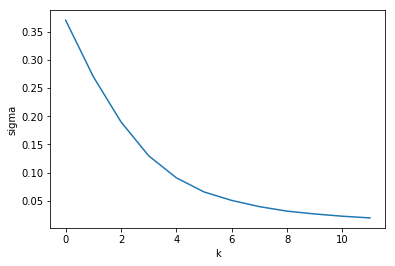

In [21]:
plt.plot(range(len(donaldson_sigma)), donaldson_sigma)
plt.xlabel('k')
plt.ylabel('sigma')

compare time efficiency donaldson vs neural network

In [22]:
# read out from above
average_t = 3

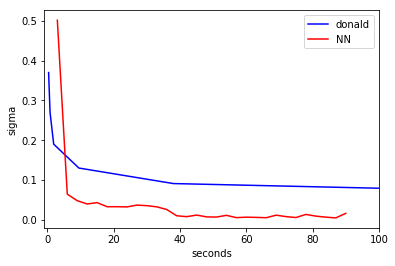

In [23]:
plt.plot(donaldson_time, donaldson_sigma, color='blue', label='donald')
plt.plot(np.arange(3, average_t*(nEpochs+1), average_t), history.history['val_loss'], color='red', label='NN')
plt.xlabel('seconds')
plt.xlim([-1, average_t*nEpochs + 10])
plt.ylabel('sigma')
plt.legend(loc='best')

## Exercises

ML:
1. Try more hyperparameters.
2. Implement your own grid search.
3. Implement your own random search.

BO:
1. Use [TPE](https://github.com/hyperopt/hyperopt) or [Hyperband](https://arxiv.org/abs/1603.06560) (some [implementation](https://docs.ray.io/en/latest/tune/api_docs/schedulers.html?highlight=hyperband#hyperband-tune-schedulers-hyperbandscheduler)) or [BOHB](https://github.com/automl/HpBandSter) to further tune hyperparameters.
2. Don't work too much on this. I'm hoping to get some results published at some point :)